# 机器学习纳米学位
猫狗大战毕业项目   
张斌   
 
2019年3月6日   

## I. 问题的定义

### 项目概述

本项目为kaggle竞赛项目，是要训练⼀个机器学习模型， 最终输入⼀张图片来分辨图像中是猫还是狗。本项目是⼀个典型的计算机视觉问题中的图像⼆分类问题。本项目使用卷积神经网络CNN，卷积神经网络是深度学习技术中极具代表的网络结构之⼀，在图像处理领域取得了很大。本项目的输入集是由“Dogs vs. Cats Redux: Kernels Edition”项目提供的训练集和测试集，通过利用kaggle下载的训练集图片，利用CNN网络对图片进行多次积层和池化层处理，在输出层进行sigmoid计算得到两个类别各自的概率，通过损失函数的值对模型的各个参数进行调整，不断的评分，不断的调整，最终训练出优秀的模型。利用最终的模型，对测试集中的每个图像，预测图像是狗的概率（1 =狗，0 =猫）。  

### 问题陈述
这次需要解决的问题是：通过利用计算机图像识别技术，对kaggle提供的训练集数据利用CNN的方式进行分析学习训练出优秀的图像识别模型，利用图像识别模型对测试集中的图片进行预测，预测图像是狗或猫的概率，并将结果存入sample_submission.csv文件中，上传至kaggle进行打分。   
1、首先将对数据集中的图片进行筛选，利用箱型图原理，剔除异常的图片，主要包含低分辨率和错误的图片。     
2、建立训练集和验证集。   
3、由于神经网络输入点图像的维度和像素是固定的，通过对图像进行预处理，统一图像的维度。     
4、利用迁移学习，使用开源的优秀的图像识别模型并加载权重作为固定的图像特征提取器，利用多个具有优秀权重的识别模型对数据进行预处理，观察各自的预测结果的准确率和多个模型联合起来的预测结果准确率。   
5、结合迁移学习的模型，建立CNN的数据模型。      
6、对CNN模型进行训练，得到最优的模型。   
7、利用模型预测测试集中的图像是狗的概率，将结果按照要求存入sample_submission.csv文件中。   
期望的结果是训练出的模型可以准确的识别出图像是狗还是猫，并在kaggle上得到优秀评分。   

### 评价指标
kaggle的评估标准是log损失函数，以下为表达式：   
$LogLoss = -\frac{1}{n}\sum_{i=1}^n [y_ilog(\hat{y}_i)+(1-y_i)log(1- \hat{y}_i)]$

其中：   
n 是测试集中图片数量。   
$\hat{y}_i$是图片预测为狗的概率。   
${y}_i$如果图像是狗，则为1，如果是猫，则为0。   
$log()$是自然对数。   
对数损失越小，代表模型的性能越好。    

交叉熵是分类问题中常用的损失函数，被广泛应用。
我使用的评估指标是kaggle提出了，首先保证的评估指标的适用性。以上计算公式摘自kaggle“Dogs vs. Cats Redux: Kernels Edition”项目。

## II. 分析

### 数据的探索
此数据集来自kaggle“Dogs vs. Cats Redux: Kernels Edition”项目。全部解压后包括：train、test、sample_submission.csv。    
![title](img/1.jpg)
train文件夹中包含25000 张猫狗的图片，每张图片的名字为“类型+序号.jpg”，此文件夹为训练集，用训练集图片对模型进行训练，根据图片的名称可以定义图片中的内容为猫或狗。   

 ![title](img/2.jpg)
test文件夹中包含12500张猫狗的图片，每张图片的名字为“序号.jpg”，此文件夹为测试集，利用算法模型预测测试集中图片的内容（即图片中是狗的概率），并将结果存入sample_submission.csv。     
sample_submission.csv文件内需要将模型预测的测试集中图片是狗的概率和图片序号一一对应填入，最终上传至kaggle打分。   

In [4]:
files = glob('data/train/*')

In [5]:
test_files = glob('data/test/*')

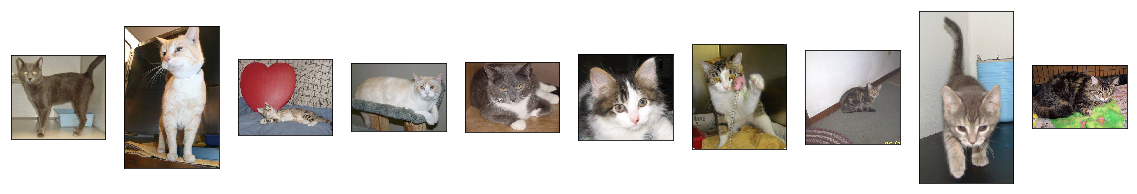

In [4]:
fig = plt.figure(figsize=(20,10))
for i, val in enumerate(files[50:60]):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    abnormal_img = Image.open(val) 
    # 异常图片名称,待添加
    ax.imshow(abnormal_img)

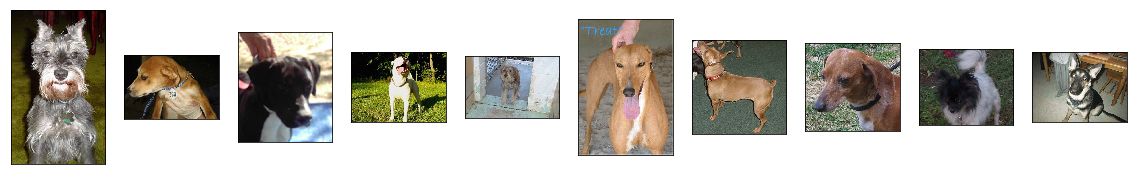

In [6]:
fig = plt.figure(figsize=(20,10))
for i, val in enumerate(files[12510:12520]):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    abnormal_img = Image.open(val) 
    # 异常图片名称,待添加
    ax.imshow(abnormal_img)

以上为kaggle“Dogs vs. Cats Redux: Kernels Edition”项目提供的部分数据内容。

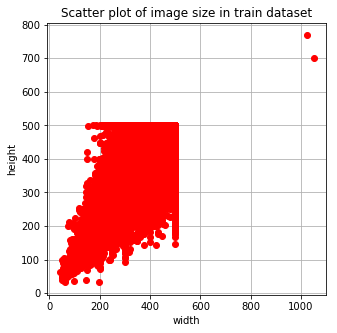

In [21]:
scatter_plot(files, 'train')

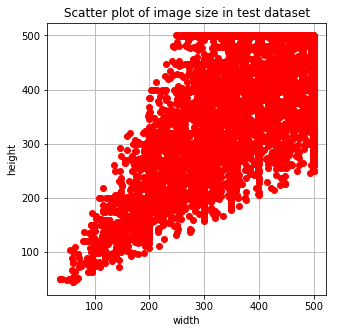

In [22]:
scatter_plot(test_files, 'test')

kaggle提供的train和test中的图片，以上是图片长宽的散点图，上图说明图片的大小有一定差别，需要在输入模型前统一大小，并且有些图片的像素相比其他图片是过于低的，这个也应引起注意。   
kaggle提供的数据集中，应重点关注训练集train中异常的图片，主要包括分辨率过低，图片大小太小等。对train中所有的图片进行图像直方图分析，对图片中包含的色彩与图片的像素的比值进行分析，此次利用箱型图原理，显示一组数据分散情况，箱形图为我们提供了识别异常值的一个标准：异常值被定义为小于Q1－1.5IQR或大于Q3+1.5IQR的值，从而筛选出异常值，并剔除。以下是箱型图和异常值，圆圈代表异常值，我们应该对异常值进行剔除。通过箱型图原理判断的异常值总共220张。

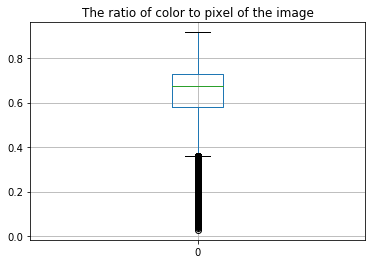

In [12]:
df = pd.DataFrame(color_pixel_ratio_list)
f = df.boxplot()  # 返回类型为字典
plt.title('The ratio of color to pixel of the image')
plt.show()

In [ ]:
# # 异常图片list
# abnormal_pic_list = []
# for key, value in color_pixel_dict.items():
#     # 判断小于异常值
#     if key < abnormal_1:
#         # 加入异常pic列表中
#         abnormal_pic_list.append(value)
#         # 打开异常pic，并展示
        
#     # 判断大于异常值
#     if key > abnormal_2:
#         # 加入异常pic列表中
#         abnormal_pic_list.append(value)
        
# # 输出所有异常picture        
# print('异常图片的数量为：' + str(len(abnormal_pic_list)) + '张')
# # 显示异常图片


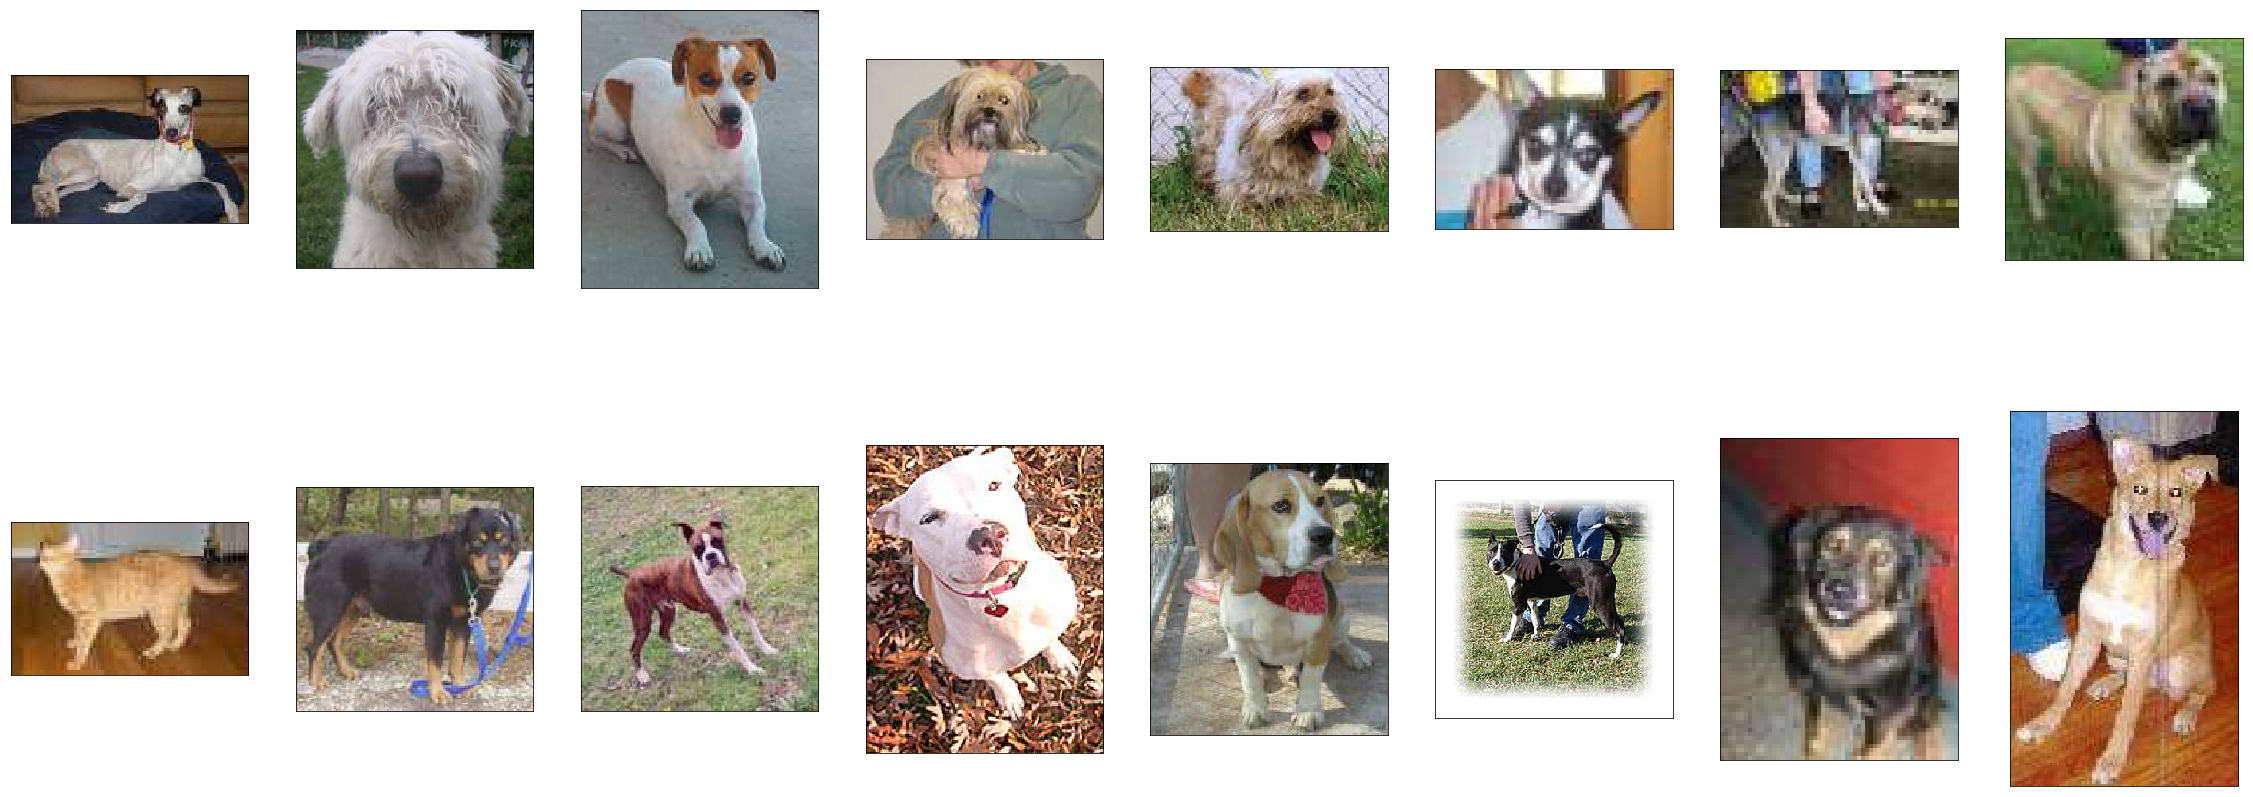

In [12]:
fig = plt.figure(figsize=(40,40))
for i, val in enumerate(abnormal_pic_list[:16]):
    ax = fig.add_subplot(5, 8, i + 1, xticks=[], yticks=[])
    abnormal_img = Image.open(str(val)) 
    # 异常图片名称,待添加
    ax.imshow(abnormal_img)

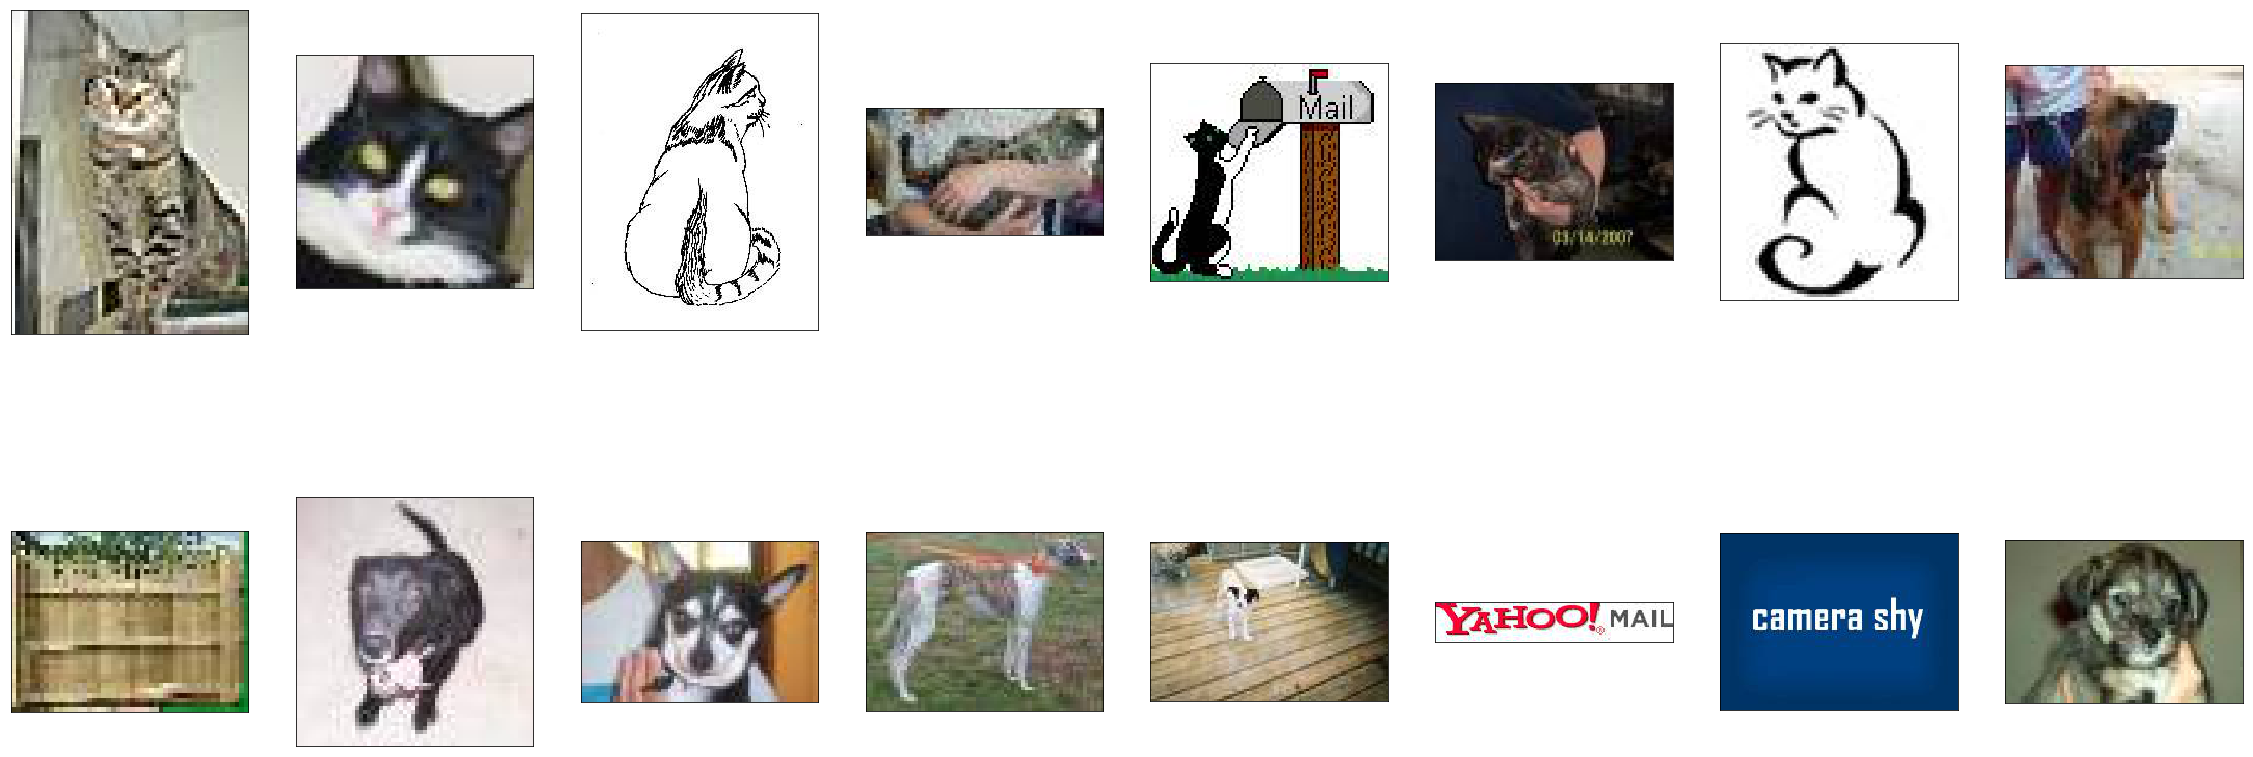

In [13]:
fig = plt.figure(figsize=(40,40))
for i, val in enumerate(inin['inin'][:-7]):
    ax = fig.add_subplot(5, 8, i + 1, xticks=[], yticks=[])
    abnormal_img = Image.open('data/train/' + str(val)) 
    # 异常图片名称,待添加
    ax.imshow(abnormal_img)

以上为判断为异常值的部分图片，其中也包含一些正常的图片，但是由于220张在25000张图片中的比例较小，所以为了方便，将220张图片全部剔除。   
      
      

### 算法和技术
对给定的图片，计算机识别图片的内容，预测出图像属于预先定义类别中的哪⼀类，属于计算机视觉领域，本项目是二分类的问题，目前解决这类问题的核心技术框架是深度学习，针对图像类型的数据，深度学习中的卷积神经网络架构CNN又性能突出,卷积神经网络是一类包含卷积计算且具有深度结构的前馈神经网络，卷积神经网络能够进行平移不变分类，因此也被称为“平移不变人工神经网络。CNN网络层级结构主要有5个层级结构：
 - 1.输入层
 - 2.卷积层
 - 3.激活层
 - 4.池化层
 - 5.全连接层   
**输入层**   
卷积神经网络的输入层可以处理多维数据，接收外部传入数据的一层，由于使用梯度下降进行学习，卷积神经网络的输入特征需要进行标准化处理。   
**卷积层**   
使用卷积核进行特征提取和特征映射。   
**激活层**   
所谓激活，实际上是对卷积层的输出结果做一次非线性映射。如果不用激活函数，这种情况下，每一层的输出都是上一层输入的线性函数。   
**池化层**   
在卷积层进行特征提取后，输出的特征图会被传递至池化层进行特征选择和信息过滤。池化层包含预设定的池化函数，其功能是将特征图中单个点的结果替换为其相邻区域的特征图统计量，池化的功能是不断降低维数，以减少网络中的参数和计算次数。这缩短了训练时间并控制过度拟合。   
**全连接层**   
卷积神经网络中的全连接层等价于传统前馈神经网络中的隐含层。全连接层通常搭建在卷积神经网络隐含层的最后部分，并只向其它全连接层传递信号。特征图在全连接层中会失去3维结构，被展开为向量并通过激活函数传递至下一层或输出层。   

![title](img/3.jpg)

输入层读入图像作为网络的数据输入，经过多个卷积层、激活层、池化层卷积后，神经网络主要是对图片的特征向量进行抽取，最后进入全连接层判断对象的类别，因此可以利用已经训练好的卷积神经网络提取图片中复杂的几何特征，即将原始图片用已经训练好的卷积神经网络处理之后的输出，作为新的输入，然后加上定制的全连接层，去进行分类。在模型训练的过程中，只改变新加的全连接层的权重，对模型进行优化。卷积神经网络是⼀种特殊的神经网络结构，可以通过卷积操作实现对图像特征的优化提取，提炼视觉特征提供图像分类的准确率。    
卷积神经网络在计算机图像识别技术中优势突出，是一种优秀的神经网络，在图像识别的工作中，选择最适合的卷积神经网络模型将能保证极高的准确率。在选择成熟的神经网络卷积层的过程中，由于不同模型的优缺点不同，计划比较InceptionResNetV2，InceptionV3，ResNet50，Xception四个高准确率的模型的优劣，并将组合四个神经网络模型或三个神经网络模型进行拼接，传入定制全连接层，利用交叉熵损失函数训练出最优模型，最终比较单独选用InceptionResNetV2，InceptionV3，ResNet50，Xception之中一种模型和使用以上四个模型进行拼接或其中三个进行拼接的模型中，那个模型预测图片分类的准确率高。
依据Udacity学习的经验，本次计划使用Keras框架实现以上功能。
### 模型的选择
**InceptionResNetV2**     
它在ILSVRC图像分类基准测试中实现了当下最好的成绩。Inception-ResNet-v2是早期Inception V3模型变化而来，从微软的残差网络（ResNet）论文中得到了一些灵感。
![title](img/4.jpg)
Inception-ResNet-v2图中最上部分，你能看到整个网络扩展了。注意该网络被认为比先前的Inception V3还要深一些。在图中主要部分重复的残差区块已经被压缩了，所以整个网络看起来更加直观。另外注意到图中inception区块被简化了，比先前的Inception V3种要包含更少的并行塔。

如下方图表所示，Inception-ResNet-v2架构的精确度比之前的最优模型更高，图表中所示为基于单个图像的ILSVRC 2012图像分类标准得出的排行第一与排行第五的有效精确度。此外，该新模型仅仅要求两倍于Inception v3的容量与计算能力。
![title](img/7.jpg)

**ResNet50：**   
ResNet（Residual Neural Network）由微软研究院的Kaiming He等四名华人提出，通过使用ResNet Unit成功训练出了152层的神经网络，并在ILSVRC2015比赛中取得冠军，在top5上的错误率为3.57%，同时参数量比VGGNet低，效果非常突出。ResNet的结构可以极快的加速神经网络的训练，模型的准确率也有比较大的提升。同时ResNet的推广性非常好，甚至可以直接用到InceptionNet网络中。
ResNet的主要思想是在网络中增加了直连通道，即Highway Network的思想。此前的网络结构是性能输入做一个非线性变换，而Highway Network则允许保留之前网络层的一定比例的输出。ResNet的思想和Highway Network的思想也非常类似，允许原始输入信息直接传到后面的层中。 这样的话这一层的神经网络可以不用学习整个的输出，而是学习上一个网络输出的残差，因此ResNet又叫做残差网络。
![title](img/5.jpg)


这种残差跳跃式的结构，打破了传统的神经网络n-1层的输出只能给n层作为输入的惯例，使某⼀层的输出可以直接跨过几层作为后面某⼀层的输入，其意义在于为叠加多层网络而使得整个学习模型的错误率不降反升的难题提供了新的方向。在此之前，深度神经网络常常会有梯度消失问题的困扰，即来⾃误差函数的梯度信号会在反向传播回更早的层时指数级地下降。本质上讲，在误差信号反向回到更早的层时，它们会变得非常小以⾄于网络无法学习。但是，因为ResNet 的梯度信号可以直接通过捷径连接回到更早的层，所以⼀下子就可以构建 50 层、101 层、152 层甚⾄1000 层以上的网络了，而且它们的表现依然良好。那时候，这在当时最佳的基础上实现了巨⼤的飞跃（这个22层的网络赢得了 ILSVRC 2014 挑战赛）。

**Xception：**   
Xception 实际上采用了类似于 ResNet 的网络结构，主体部分采用了模块化设计。Xception 结构如下图所示，分为Entry flow; Middle flow; Exit flow; Entry flow 包含 8个conv；Middle flow 包含 3X8 =24个conv；Exit flow包含4个conv，所以Xception共计36层。
![title](img/6.jpg)
Xception 是对Inception v3的改进，是一种 Extreme Inception，因而得名 Xception，其主要是借鉴（非采用）depthwise separable convolution来替换原来Inception v3中的卷积操作。

**Inception V3：**   
Inception 网络是 CNN 分类器发展史上一个重要的里程碑。在 Inception 出现之前，大部分流行 CNN 仅仅是把卷积层堆叠得越来越多，使网络越来越深，以此希望能够得到更好的性能。
Inception v3 整合了前面 Inception v2 中提到的所有升级，还使用了：
- RMSProp 优化器；
- Factorized 7x7 卷积；
- 辅助分类器使用了 BatchNorm；
- 标签平滑。   
Inception V3避免网络表达瓶颈，尤其在网络的前端。feature map急剧减小，这样对层的压缩过大，会损失大量信息，模型训练困难；高维特征的局部处理更困难；在较低维度空间聚合，不会损失表达能力；平衡网络的宽度和深度。

在2015年12⽉提出的 Inception V3结构借鉴 Inception 的结构设计了采用⼀种并行的降维结构，如下图：
![title](img/b2.jpg)
经过优化后的inception v3网络与其他网络识别误差率，如表所示：
![title](img/b1.jpg)

** 以下为各个模型比较情况** 
![title](img/a1.jpg)

从以上图中的比较，完全可以说明利用以上模型的合理性，本次选取的多个模型均已在实战中得到了优异的成绩。
InceptionResNetV2，InceptionV3，ResNet50，Xception四个模型的关键参数设定为：（weights='imagenet', include_top=False），weights='imagenet'代表加载预训练权重，include_top=Fals表示不保留顶层的3个全连接网络。

### 基准模型   
本项目的最低要求是kaggle Public Leaderboard前10%。   
在kaggle上，总共有1314只队伍参加了比赛，前10%为131位之前，131位的得分是0.06127，所以模型预测结果分数要小于0.06127。

## III. 方法

### 数据预处理

首先将对train数据集中进行箱型图分析后的异常值进行分析，异常值共计220张，删除后train数据集中图片为24780张，test测试集中图片为12500张，清理的图片已在上文可视化了部分内容。之后利用train中的数据随机抽取20%建立验证集。    
由于神经网络输入点图像的维度和像素是固定的，通过对图像进行预处理，统一图像的维度和像素。

### 执行过程
#### 生成迁移学习特征向量####
InceptionResNetV2,Xception，InceptionV3和ResNet50这四个模型对于输入图片都有各自的默认值，InceptionResNetV2、Xception 和 InceptionV3 默认输入图片大小是(299,299)，ResNet50 默认输入图片大小是(224,224)；在将图片输入模型前，首先使用每个模型的预处理函数 preprocess_input，将数据处理成该模型的标准输入。    
常见的卷积神经网络结构在前面的若干层都是卷积池化层及其各种变种，后面几层都是全连接层，这些全连接层之前的网络层被称为瓶颈层 (bottleneck). 将新的图片通过训练好的卷积神经网络直到瓶颈层的过程可以看做是对图像进⾏特征提取的过程。⼀般情况下，为了减少内存的消耗， 加快计算的过程，再将瓶颈层的结果输入全连接层之前，做⼀次全局平均池化，为数据下一步进入定制层进行降维，加快速度的同时，也降低过拟合的程度。在经过全局平均池化后，每个模型都将图片处理成⼀个行向量。在得到提取的迁移学习特征向量后，将数据存入npz文件中，待后续使用。     
以下为生成迁移学习特征向量相关函数代码：

#### 载入特征向量####

经过上面的代码运算，得到特征向量，分别是：
- cat_dog_Xception.npz；
- cat_dog_InceptionResNetV2.npz；
- cat_dog_ResNet50.npz；
- cat_dog_InceptionV3.npz；   
在下一步载入各个特征向量，分别6次运行以下函数，每次运行需清除之前的数据。    
预测6次分别是：    
- 单独载入cat_dog_Xception特征向量；
- 单独载入cat_dog_InceptionResNetV2特征向量；
- 单独载入cat_dog_ResNet50特征向量；
- 单独载入cat_dog_InceptionV3特征向量；
- 载入将四个特征向量通过np.concatenate函数进行连接生成的特征向量。
- 载入将三个特征向量cat_dog_Xception、cat_dog_InceptionResNetV2、cat_dog_InceptionV3通过np.concatenate函数进行连接生成的特征向量。

通过运行`X_train, y_train = shuffle(X_train, y_train)`将训练集中的数据打乱。   
#### 构建模型####
构建定制的模型，载入预处理的特征向量数据，对数据进行概率为 0.5 的'dropout'，然后连接一层输出为X_train.shape[1]/2、激活函数为tanh的连接层，再对数据进行概率为0.5的'dropout'，最后连接输出层，激活函数为Sigmoid，输出2个类别各自可能的概率，本次的优化器采用为'rmsprop'，损失函数为'binary_crossentropy',评判使用'accuracy'。

#### 训练模型####

以下是训练模型，对模型进行10次训练，将最优模型保存在'data/model.weights.best.hdf5'中。

在以上的训练中，分别使用每组特征向量和四个特征向量组合的特征向量和三个特征向量组合的特征向量训练模型，比较损失函数值，比较最优的模型，如下：

**InceptionV3特征向量情况**      
![title](img/InceptionV3.jpg)
**InceptionResNetV2特征向量情况**       
![title](img/netv2.jpg)
**ResNet50特征向量情况**       
![title](img/ResNet50.jpg) 
**Xception特征向量情况**          
![title](img/Xception.jpg)    









**组合4个特征向量情况**    
![title](img/err.jpg)   
**组合3个特征向量情况**    
![title](img/3v.jpg)

在训练的过程中发现，四个特征向量组合获得的特征向量在训练过程中的loss一直保持在8.0289，而且没有变好的情况，可能是由于4个特征向量之间存在冲突或是复杂度过高，导致特征的提取反而劣化。在剩余的几次训练的对比中，发现三个特征向量组合获得的特征向量在训练中的loss为最优，达到0.0164。所以最终选用0.0169最低的模型（三个特征向量cat_dog_Xception、cat_dog_InceptionResNetV2、cat_dog_InceptionV3通过np.concatenate函数进行连接生成的特征向量），在确定了模型后，对定制层进行增加和修改，选择最优的层数。在确定了训练模型的层次后，对'nadam'、'adadelta'、'rmsprop'几个优化器进行了比较，之间的差距也并不大，最终确定使用'rmsprop'优化器。
#### 预测测试集####
预测这里我们用到了一个小技巧，我们将每个预测值限制到了 [0.005, 0.995] 个区间内，这个原因很简单，kaggle 官方的评估标准是 LogLoss，对于预测正确的样本，0.995 和 1 相差无几，但是对于预测错误的样本，0 和 0.005 的差距非常大。    
此处采用了[手把手教你如何在Kaggle猫狗大战冲到Top2%](https://zhuanlan.zhihu.com/p/25978105?utm_medium=social&utm_source=weibo)中的建议。

### 完善
本次从初始开始，主要完善并修改了以下几部分：
- 特征向量提取模型选择：如上所述，分6次载入不同特征向量，最终根据各自的验证集loss值，选择了有三个特征向量组成的特征向量；
- 对数据的定制层进行调整：主要初始是使用了一个0.3的'dropout'和model.add(Dense(2, activation='sigmoid')),但是发下数据的验证机准确率总是在90%左右，并比训练集准确率低，所以考虑是过拟合的原因，将'dropout'调整为0.5后有一定改善。但是预测准确率没有到达要求，在0.5的'dropout'前增加了0.5的'dropout'层和Dense(int(X_train.shape[1]/2), activation='tanh')层，对数据预测结果有一定的优化作用；
- 对模型的优化器进行调整，选用了'nadam'/'adadelta'/'rmsprop'/'SGD'/'adam'等,最终发现'rmsprop'效果最好；
- 对模型的训练测试进行了调整，总结发现在10次性能成本最优；
- 对模型的batch_size进行了调整，分别测试了1024、512、256、128、64、32，发现不同情况下的收敛不同，如果模型发生loss不降低的情况是，需要对其进行调整，最终优选128；
- 下一步应添加图像数据增强，要对原始图片进行⼀些随机操作，比如旋转、剪切变换、缩放、⽔平翻转等，降低模型的过拟合。
- 应对train数据集异常数据的剔除根据准确，可能可以进一步的提升准确率。



## IV. 结果

### 模型的评价与验证
![title](img/jieguo.jpg)

在验证集上达到了99.62%的准确率loss为0.0164，
训练过程中的 loss 和 accuracy 如下：
![title](img/1.png)
![title](img/2.png)

将测试集的处理结果提交到kaggle上，loss为0.03891。
![title](img/a5.jpg)

通过以上可视化的分析，训练集和验证机的损失函数曲线变化的收敛程度是相同的，而且是稳定的，最终都到达了损失函数特别低的程度，并基本重合，所以表明模型对于这个问题是足够稳健可靠，训练数据或输入的一些微小的改变不会极大影响结果。测试集的预测结果上传至kaggle上评分，loss为0.03891，说明这个模型得出的结果是可信的。    

### 合理性分析


单个ResNet50模型10次迭代训练结果为：      
训练集loss：0.0391，验证集loss：0.0320。      
单个Xception模型10次迭代训练结果为：      
训练集loss：0.0179，验证集loss：0.0190。      
单个InceptionV3模型10次迭代训练结果为：      
训练集loss：0.0191，验证集loss：0.0194。   
单个InceptionResNetV2模型10次迭代训练结果为：     
训练集loss：0.0100，验证集loss：0.0200。   
三个模型10次迭代训练结果为：      
训练集loss：0.0128，验证集loss：0.0169。    
四个模型10次迭代训练结果为：     
训练集loss：8.02，验证集loss：7.96。        
三种模型通过组合，优于其他的情况。           
更多的层数，不同的卷积核各种各样的的组合，可以更好的抽取图片中的泛化特征，这样既可以提高分类的准确率，又可以降低模型的过拟合，所以现在神经网络层数都非常的多，深度很深，但是从此次的训练中发现，过于复杂的模型也会带来‘梯度消失’等的问题，导致模型损失函数的提高，所以选择更深层次更复杂的模型的同时也要考虑带来的负面影响，要有相应的办法去处理、减少负面的影响，在深层次复杂模型和‘梯度消失’等其他负面影响之间选择平衡，选择最优的模型。              
InceptionV3、XceptionInceptionV3和InceptionResNetV2这三个模型进行组合迁移学习，效果比单个神经网络模型效果和4个神经网络模型更好，也在这次的实验中得到了体现，也充分说明了模型层次深、复杂度高和‘梯度消失’等负面影响之间的平衡问题。在尽量降低‘梯度消失’等负面影响的前提下，提高模型的复杂度，通过多个模型处理数据并进行组合，可以有效降低模型的方差，减少过拟合程度，提高分类准确率。       
通过上传预测结果数据到kaggle上进行打分，结果已完全说明此模型的预测结果完全满足前面设定的基准模型的要求，确确实实解决了此次的问题。

## V. 项目结论

### 结果可视化

![title](img/jieguo.png)

![title](img/model.jpg)

图片上方的概率表示的是图片中是狗的概率，越接近1表示为狗，越接近0预测为猫。并且从kaggle上的得分结果，充分说明了此次训练出的CNN模型对于图片预测准确度是相当高的。从模型概况图也充分说明了合理性分析中的相关理论，在取得模型深层次复杂度和‘梯度消失’等负面影响平衡后的CNN模型，完全能达到项目的要求。

### 对项目的思考

深度学习卷积神经网络毫无疑问是处理图像问题最佳的机器模型，近年来各大赛的前几名均是通过深度学习获取好成绩。本项目首先对训练数据中的异常数据进行了清理，统一输入图片的大小和生成了随机的训练集和验证集，之后利用现有的优秀模型对数据进行了特征向量的提取，本次选用了Xception、InceptionV3 、ResNet50和InceptionResNetV2四个模型，之后对三组特征向量和4组特征向量进行了组合，并对单独使用一组特征向量和组合后的特征向量的数据输入定制模型中进行训练，最终比较发现选择更复杂的模型的同时也要考虑带来的负面影响，要有相应的办法去处理、减少负面的影响，在复杂的模型带来优势和劣势中找到平衡，选择最优的模型。最终发现此次项目选用Xception、InceptionV3 和InceptionResNetV2三组特征项目组成的模型，在最终预测中得分最高。   
在此次的项目试验中，我也陷入了困境，先入为主的认为4个特征向量的组合会带来更好的预测结果，所以无数次的对4个特征向量组合的进行训练，调整了定制层的深度、激活函数等，调整了优化器、评判标准等，并不断的修正代码，但是最终也无法降低模型的损失函数，在这种情况下困惑了10几天，最终突然认识到可能是CNN网络过多的组合和层次带来了负面效应。最终通过实验的方式得到了最优结果（三个模型的组合）。通过此次的项目和困惑，也充分认识到深度学习这门计算机技术，应更注重于实践的结果，实践结果是验证模型最好的方式，而不像传统计算机编程技术，注重的是代码的逻辑性。在深度学习中，实验占第一位，代码逻辑在第二位。本次项目只是使用Xception、InceptionV3、InceptionResNetV2 和 ResNet50 四个模型进行实验，并且只是简单的拼接，忽略了特征之间的位置关系，除了这四个模型，还可以选择更多新的模型，或者使用stacking的方法进行模型融合，进⼀步降低方差，寻找网络复杂度与模型负面影响最低化的方案，提高分类的准确率。对于数据清理部分，此次项目我只是粗鲁的分析和删除了异常数据，其实异常数据中还有很多正常数据，所以下一步应更精确的删除异常图片，从而提高训练集的数据量，并加入图片增强的技术，进一步的提高模型的预测准确度。   
最终模型和结果完全符合我对这个问题的期望，我认为它完全可以在通用的场景下解决这些类型。   

### 需要作出的改进

本次的项目我使用的是Keras框架，其实Keras框架的基础是TensorFlow，为了提高运算的速度，下一次我应该学习TensorFlow语法，直接使用google公司提供的更加先进的方法，利用TensorFlow来训练模型。    
由于本次项目Keras框架对NASNetLarge模型的支持存在部分问题，无法利用这个被现今誉为最好的CNN模型，在下一步中，我可能利用此模型进一步提高我的模型的准确度。    
在此次的执行流程中，没有加入k-折叠交叉验证和图像增强的技术，在下一步的完善中，通过加入这两种技术也将进一步提高我的模型的准确度。    



## IV. 参考文献

[1][手把手教你如何在Kaggle猫狗⼤战冲到Top2%](https://zhuanlan.zhihu.com/p/25978105)    
[2][python用matplotlib绘制散点图、直方图、箱形图](https://jingyan.baidu.com/article/0aa223757124e088cd0d6444.html)      
[3][Keras 中文文档](https://keras.io/zh/)      
[4][InceptionResNetV2](https://arxiv.org/abs/1602.07261)      
[5][在AWS上配置深度学习主机](https://zhuanlan.zhihu.com/p/25066187)      
[6][ImageNet: VGGNet, ResNet, Inception, and Xception with Keras](https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/)     
[7][Inception-Resnet-V2的网络模型](https://www.cnblogs.com/yuehouse/p/9742647.html)   
[8][面向小数据集构建图像分类模型](https://keras-cn.readthedocs.io/en/latest/legacy/blog/image_classification_using_very_little_data/#bottleneck90)   
[9][机器学习基础与实践（一）----数据清洗](http://www.cnblogs.com/charlotte77/p/5606926.html)       
[10][python使用matplotlib:subplot绘制多个子图](https://blog.csdn.net/gatieme/article/details/61416645)         
[11][Matplotlib绘图常见设置说明](https://www.cnblogs.com/nju2014/p/5707980.html)         
[12][利用AWS学习深度学习 For Udacity P5](https://zhuanlan.zhihu.com/p/33176260)        
[13][Documentation for individual models](https://keras.io/applications/#documentation-for-individual-models)        
[14][Dogs vs. Cats: Image Classification with Deep Learning using TensorFlow in Python](https://www.datasciencecentral.com/profiles/blogs/dogs-vs-cats-image-classification-with-deep-learning-using)        


In [14]:
from PIL import Image
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
def scatter_plot(files, flor):
    size = []
    for pic in files:
        img = Image.open(pic)
        size.append(img.size)
        size_1 = np.array(size)
    plt.figure(figsize=(5,5))
    plt.plot(size_1[:, 0], size_1[:, 1], 'ro')
    plt.grid(True)
    plt.xlabel('width')
    plt.ylabel('height')
    plt.title('Scatter plot of image size in ' + flor + ' dataset')

In [4]:
# from PIL import Image
# import os
# import numpy as np
# # 提供文件和文件集合的高级操作，复制、删除等
# import shutil
# # 导入计数
# from collections import Counter
# # 文件操作模块
# from glob import glob
# from keras.preprocessing import image
# from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input as preprocess_input_ResNet50
# from keras.applications.xception import Xception
# from keras.applications.xception import preprocess_input as preprocess_input_Xception
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input as preprocess_input_InceptionV3
# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Sequential
# from keras.layers import  Dense, Dropout
# from keras.callbacks import ModelCheckpoint 
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D
# from keras.utils import np_utils
# import pandas as pd
# import re
# import matplotlib.pyplot as plt
# %matplotlib inline 

In [2]:
# # 利用直方图，计算图片中的色彩与图片像素的比值函数

# def calhistogram(file):
#     # 打开图片
#     img = Image.open(file)
#     # 直方图
#     his = img.histogram()
#     # 计算色彩的数量
#     count = Counter(his)
#     # 计算色彩数量和图片像素的比值
#     return float(len(count))/len(his)
# # 建立所有图片色彩和图片像素的比值的list
# color_pixel_ratio_list = []
# for train_file in files:
#     color_pixel_ratio_list.append(calhistogram(train_file))
# # 第一四分位数
# Q1 = np.percentile(color_pixel_ratio_list, [25])
# # 第三四分位数
# Q3 = np.percentile(color_pixel_ratio_list, [75])
# # 四分位距IQR
# IQR = Q3 - Q1

# # 异常值1
# abnormal_1 = Q1 - 1.5 * IQR
# # 异常值2
# abnormal_2 = Q3 + 1.5 * IQR
# print(Q1, Q3, IQR)

In [7]:
# 创建图片色彩和图片像素的比值和图片地址的dict
color_pixel_dict = dict(zip(color_pixel_ratio_list,files))

In [5]:
import ipywidgets as widgets
from IPython.display import display, HTML
javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}
def toggle_code(state):
    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)
    display(HTML(output))
def button_action(value):
    state = value.new
    toggle_code(state)
    value.owner.description = button_descriptions[state]
state = False
toggle_code(state)
button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")
display(button)